# Import dependences

In [1]:
import re
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

# Load data

In [2]:
data_path = 'data/FPT.csv'
df = pd.read_csv(data_path)
df.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,FPT,12/25/2018 9:15,30.89,30.89,30.89,30.89,35410,0
1,FPT,12/25/2018 9:16,30.81,30.81,30.81,30.81,190,0
2,FPT,12/25/2018 9:17,30.74,30.81,30.74,30.74,1120,0
3,FPT,12/25/2018 9:18,30.74,30.74,30.74,30.74,2120,0
4,FPT,12/25/2018 9:19,30.74,30.74,30.74,30.74,22500,0


In [3]:
df['Date'] = pd.to_datetime(df['Date/Time'])

In [4]:
df = df.set_index('Date')

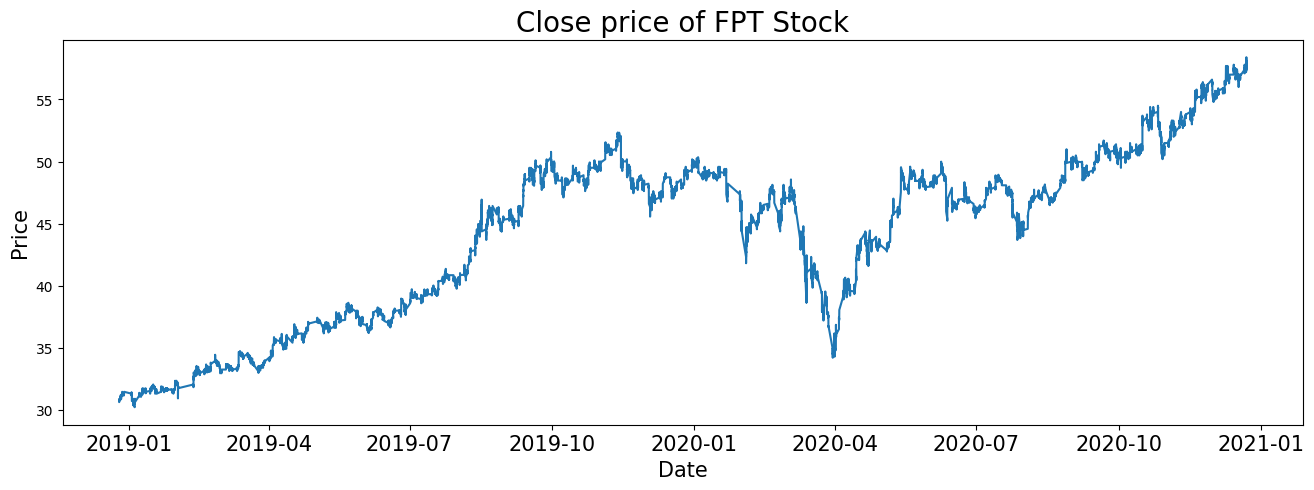

In [5]:
# Adjusting the figure size
fig = plt.subplots(figsize=(16, 5))

# Creating a plot
plt.plot(df.index, df['Close'])

# Adding a plot title and customizing its font size
plt.title('Close price of FPT Stock', fontsize=20)

# Adding axis labels and customizing their font size
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)

# Rotaing axis ticks and customizing their font size
plt.xticks(rotation=0, fontsize=15)

# plt.xlim(df.index.min(), df.index.max())

plt.show()

# Split train & test set

In [6]:
# Split data into train set and test set
data = df[['Close']]
p = int(0.8*len(data))
train, test = data[:p], data[p:]
train.shape, test.shape

((77924, 1), (19482, 1))

In [7]:
train.index.min(), train.index.max(), test.index.min(), test.index.max()

(Timestamp('2018-12-25 09:15:00'),
 Timestamp('2020-08-14 09:32:00'),
 Timestamp('2020-08-14 09:33:00'),
 Timestamp('2020-12-22 14:46:00'))

# Create predictions

In [ ]:
# Create predictions
preds = [train[-1:].sum()]
num = len(test)

for i in tqdm(range(1, num)):
    preds.append(preds[-1] + (random.random() - 0.5)*2*0.01)

100%|██████████| 19481/19481 [00:00<00:00, 32971.31it/s]


In [ ]:
# Calculate RSME Loss
rmse = np.sqrt(np.mean(np.power((np.array(test)-preds),2)))
rmse

5.351624235585102

In [ ]:
test['Predictions'] = preds

/var/folders/t6/86wyndb17fgdq0_j3t6qbkwh0000gn/T/ipykernel_3008/3404474710.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = preds


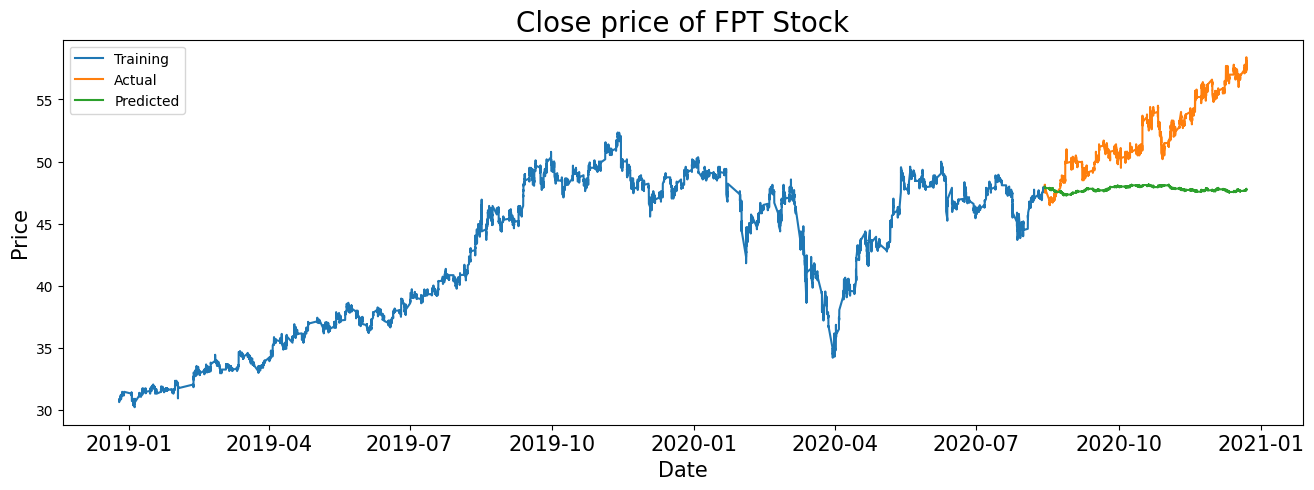

In [ ]:
# Adjusting the figure size
fig = plt.subplots(figsize=(16, 5))

# Creating a plot
plt.plot(train, label='Training')
plt.plot(test['Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')

# Adding a plot title and customizing its font size
plt.title('Close price of FPT Stock', fontsize=20)

# Adding axis labels and customizing their font size
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)

# Rotaing axis ticks and customizing their font size
plt.xticks(rotation=0, fontsize=15)

# plt.xlim(df.index[90000], df.index.max())

plt.legend()

plt.show()

# Preprocess data

In [ ]:
data['Date'] = pd.to_datetime(data.index, format='%Y-%m-%d')
data.index = data['Date']

/var/folders/t6/86wyndb17fgdq0_j3t6qbkwh0000gn/T/ipykernel_3682/880291996.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data.index, format='%Y-%m-%d')


In [ ]:
# Tạo tập dữ liệu riêng cho giá đóng cửa
data = pd.DataFrame(index=range(0, len(df)), columns=['Date', 'Close'])

for i in range(0,len(data)):
     data['Date'][i] = df.index[i]
     data['Close'][i] = df['Close'][i]

# Feature Engineering

In [ ]:
def add_datepart(df, fldname, drop=True, time=False):
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
        
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    
    if time: attr = attr + ['Hour', 'Minute', 'Second']

    for n in attr: 
        df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9

    if drop: df.drop(fldname, axis=1, inplace=True)

In [ ]:
add_datepart(data, 'Date')
data.drop('Elapsed', axis=1, inplace=True)

/var/folders/t6/86wyndb17fgdq0_j3t6qbkwh0000gn/T/ipykernel_3682/2820388501.py:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())


In [ ]:
data.columns

Index(['Close', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
       'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start',
       'Is_year_end', 'Is_year_start'],
      dtype='object')

In [ ]:
data['mon_fri'] = 0
for i in range(0,len(data)):
    if (data['Dayofweek'][i] == 0 or data['Dayofweek'][i] == 4):
        data['mon_fri'][i] = 1
    else:
        data['mon_fri'][i] = 0

/var/folders/t6/86wyndb17fgdq0_j3t6qbkwh0000gn/T/ipykernel_3682/1475073098.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mon_fri'][i] = 0
/var/folders/t6/86wyndb17fgdq0_j3t6qbkwh0000gn/T/ipykernel_3682/1475073098.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['mon_fri'][i] = 1


In [ ]:
data

,Close,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,mon_fri
0,30.89,2018,12,52,25,1,359,False,False,False,False,False,False,0
1,30.81,2018,12,52,25,1,359,False,False,False,False,False,False,0
2,30.74,2018,12,52,25,1,359,False,False,False,False,False,False,0
3,30.74,2018,12,52,25,1,359,False,False,False,False,False,False,0
4,30.74,2018,12,52,25,1,359,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97401,58.2,2020,12,52,22,1,357,False,False,False,False,False,False,0
97402,58.2,2020,12,52,22,1,357,False,False,False,False,False,False,0
97403,58.2,2020,12,52,22,1,357,False,False,False,False,False,False,0
97404,58.1,2020,12,52,22,1,357,False,False,False,False,False,False,0


In [9]:
# Split data into train set and test set
p = int(0.8*len(data))
train, test = data[:p], data[p:]
train.shape, test.shape

((77924, 1), (19482, 1))

In [10]:
X_train = train.drop('Close', axis=1)
y_train = train['Close']
X_test = test.drop('Close', axis=1)
y_test = test['Close']

In [11]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((77924, 0), (77924,), (19482, 0), (19482,))

# Time-series models

## 1. Linear Regression

In [13]:
# Create a new dataframe with only the 'Close column 
data = df.filter(['Close'])
# Convert the dataframe to a numpy array
dataset = data.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .8 ))
training_data_len

77925

In [14]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.02273535],
       [0.01989343],
       [0.01740675],
       ...,
       [0.9928952 ],
       [0.98934281],
       [0.98934281]])

In [15]:
# Create the training data set 
# Create the scaled training data set
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    # if i<= 61:
    #     print(x_train)
    #     print(y_train)
    #     print()
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

x_train.shape, y_train.shape

((77865, 60), (77865,))

In [16]:
# Create the testing data set
# Create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# Convert the data to a numpy array
x_test = np.array(x_test)

x_test.shape, y_test.shape

((19481, 60), (19481, 1))

In [18]:
from sklearn.linear_model import LinearRegression

# Tạo model
model = LinearRegression()

# Train model
model.fit(x_train, y_train)

LinearRegression()

In [22]:
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform([predictions])

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

4.10250149924999

In [21]:
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")
test['Predictions'] = 0
test['Predictions'] = preds

test.index = data[p:].index
train.index = data[:p].index

plt.plot(train['Close'], label='Training')
plt.plot(test['Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.title("Linear Regression", color = 'black', fontsize = 20)
plt.xlabel('Year', color = 'black', fontsize = 15)
plt.ylabel('Close price', color = 'black', fontsize = 15)
plt.legend()
plt.show()

ValueError: Length of values (19481) does not match length of index (19482)

<Figure size 2000x1000 with 0 Axes>

## LSTM

In [6]:
closing_price_df = df[['Close']]
closing_price_df.head() 

,Close
Date,
2018-12-25 09:15:00,30.89
2018-12-25 09:16:00,30.81
2018-12-25 09:17:00,30.74
2018-12-25 09:18:00,30.74
2018-12-25 09:19:00,30.74


In [10]:
data = closing_price_df.values
# data

In [11]:
# Split data into train set and test set
p = int(0.8*len(data))
train, test = data[:p], data[p:]
train.shape, test.shape

((77924, 1), (19482, 1))

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_train = scaler.fit_transform(data)

In [15]:
time_step = 60
X_train, y_train = [], []
for i in range(time_step, len(train)):
    X_train.append(scaled_train[i - time_step:i, 0])
    y_train.append(scaled_train[i, 0])

In [16]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [17]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(77864, 60, 1)

In [18]:
import tensorflow as tf
import keras
from keras import Sequential
from keras.layers import Dense, Dropout, LSTM

In [19]:
# Tạo và fit mạng LSTM 
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

2024-07-25 10:29:46.941353: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-07-25 10:29:46.941372: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-07-25 10:29:46.941381: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-07-25 10:29:46.941431: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-25 10:29:46.941469: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [20]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=1, batch_size=1, verbose=1)

2024-07-25 10:30:13.496750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


77864/77864 [==============================] - 1016s 13ms/step - loss: 5.8623e-05


In [21]:
# Create predictions
inputs = data[len(data) - len(test) - 60:]
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

In [22]:
# Tạo test data set
X_valid = []
for i in range(time_step, inputs.shape[0]):
    X_valid.append(inputs[i - time_step:i,0])

# Chuyển data thành numpy array
X_valid = np.array(X_valid)

# Chuyển data thành 3-D
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1],1))
preds = model.predict(X_valid)
preds = scaler.inverse_transform(preds)

609/609 [==============================] - 5s 7ms/step


In [24]:
rmse = np.sqrt(np.mean(np.power((test - preds),2)))
rmse

0.09233938834997982

/var/folders/t6/86wyndb17fgdq0_j3t6qbkwh0000gn/T/ipykernel_10934/1812342637.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = preds


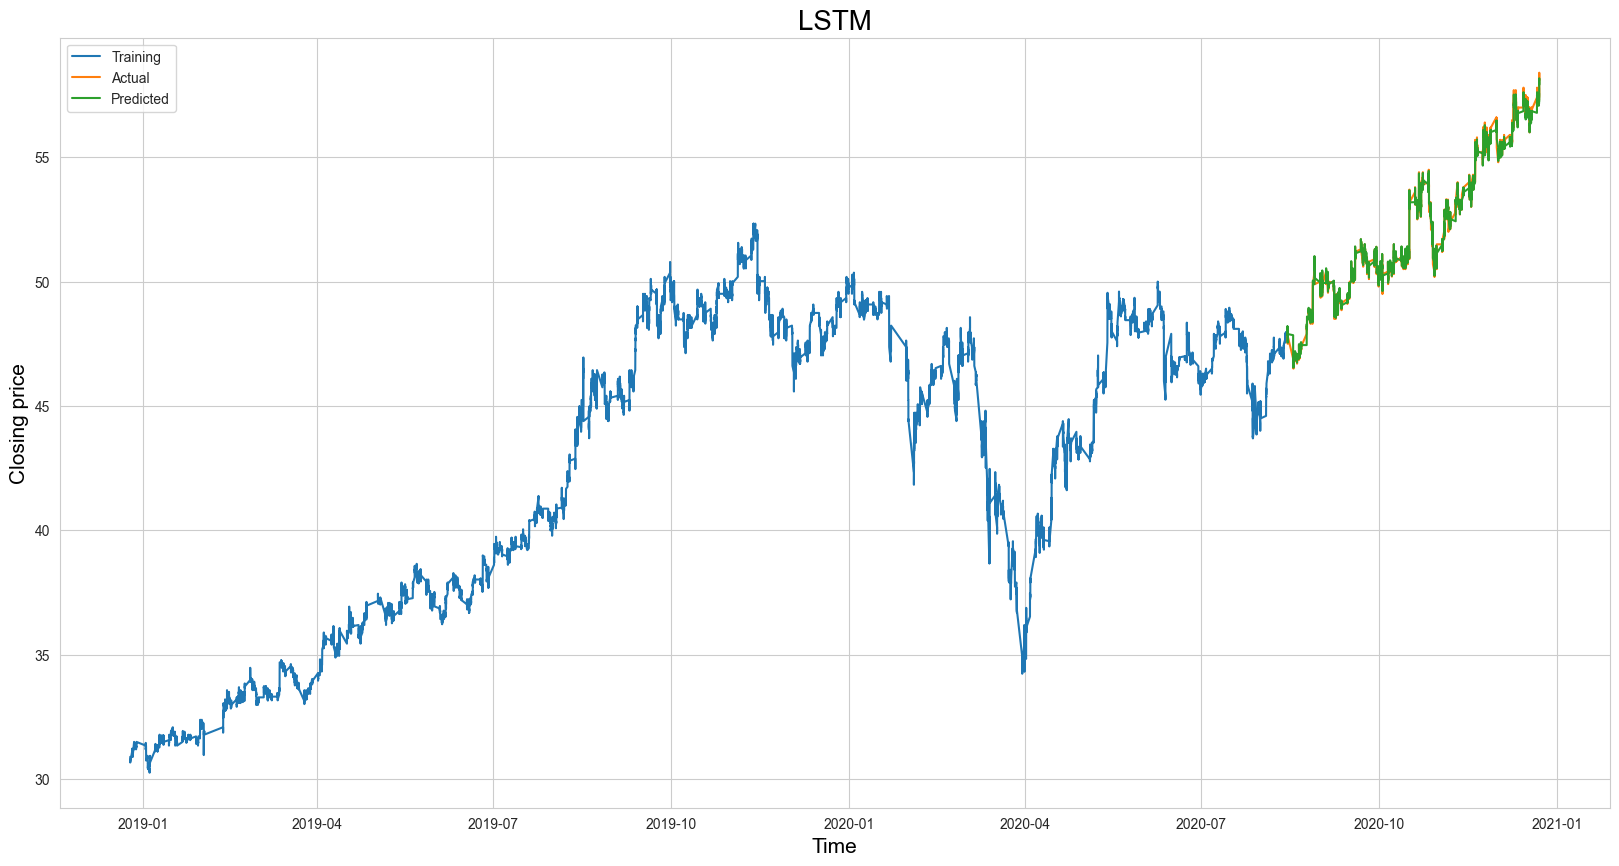

In [27]:
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")

test = closing_price_df[p:]
train = closing_price_df[:p]
test['Predictions'] = preds

plt.plot(train['Close'], label='Training')
plt.plot(test['Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
# plt.plot(future_set, label='Future')
plt.title("LSTM", color = 'black', fontsize = 20)
plt.xlabel('Time', color = 'black', fontsize = 15)
plt.ylabel('Closing price', color = 'black', fontsize = 15)
plt.legend()

# plt.xlim(test.index.min())
plt.show()

In [81]:
from datetime import timedelta

latest_row = test.iloc[-1]
latest_time = latest_row.name

minutes = 10000

future_time_list = []
for minute in range(minutes):
    future_time_list.append(latest_time + timedelta(minutes=minute))

# future_time_list

In [82]:
scaler.inverse_transform([[4]])

array([[142.85]])

In [83]:
import random


lastest_row = X_valid[-1]
future_list = []
for i in tqdm(range(minutes)):
    input_id = np.array(lastest_row).reshape((1, len(lastest_row), 1))
    pred = model.predict(input_id, verbose=0)
    lastest_row = np.append(lastest_row[1:], pred + random.random() * 0.01)
    result = scaler.inverse_transform(pred)
    future_list.append(result[0][0])

    # print(pred, result)

100%|██████████| 10000/10000 [05:15<00:00, 31.70it/s]


In [84]:
future_set = pd.DataFrame(future_list)
future_set['Date'] = pd.to_datetime(future_time_list)
future_set = future_set.set_index('Date')
# future_set

/var/folders/t6/86wyndb17fgdq0_j3t6qbkwh0000gn/T/ipykernel_10934/879828441.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = preds


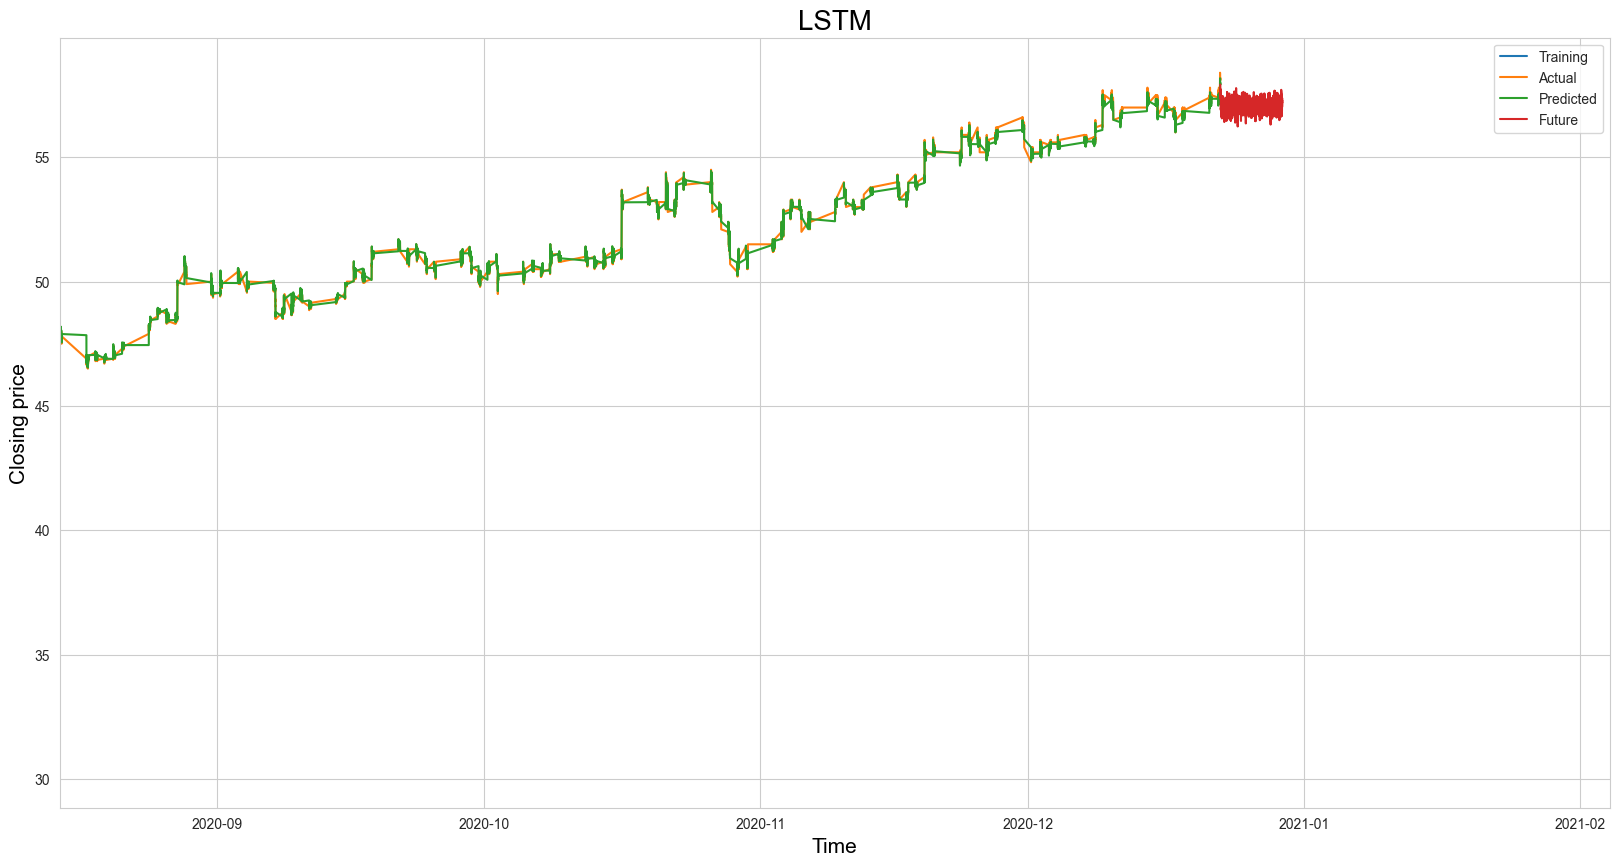

In [86]:
plt.figure(figsize=(20,10))
sns.set_style("whitegrid")

test = closing_price_df[p:]
train = closing_price_df[:p]
test['Predictions'] = preds

plt.plot(train['Close'], label='Training')
plt.plot(test['Close'], label='Actual')
plt.plot(test['Predictions'], label='Predicted')
plt.plot(future_set, label='Future')
plt.title("LSTM", color = 'black', fontsize = 20)
plt.xlabel('Time', color = 'black', fontsize = 15)
plt.ylabel('Closing price', color = 'black', fontsize = 15)
plt.legend()

plt.xlim(test.index.min())
plt.show()

In [242]:
exit()